In [ ]:
# Install required libraries if not already installed
!pip install pandas matplotlib seaborn


In [62]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive if loading from drive
# from google.colab import drive
# drive.mount('/content/drive')

# Load JSON data
with open('/content/user-wallet-transactions.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Confirm columns and sample
print(df.columns.tolist())
print(df.head())


['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt']
                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a

In [63]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


In [64]:
# Extract 'amount' from actionData dictionary
df['amount'] = df['actionData'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None)

# Convert to numeric, handling large string numbers
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Confirm extraction
print(df[['userWallet', 'action', 'amount']].head())


                                   userWallet            action        amount
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit  2.000000e+09
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit  1.450000e+20
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  1.000000e+15
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  4.000000e+15
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying  5.015480e+05


In [65]:
pivot = df.pivot_table(index='userWallet',
                       columns='action',
                       values='amount',  # changed from 'actionData.amount' to 'amount'
                       aggfunc='sum',
                       fill_value=0).reset_index()

print(pivot.head())



action                                  userWallet        borrow  \
0       0x00000000001accfa9cef68cf5371a23025b6d4b6  0.000000e+00   
1       0x000000000051d07a4fb3bd10121a343d85818da6  0.000000e+00   
2       0x000000000096026fb41fc39f9875d164bd82e2dc  0.000000e+00   
3       0x0000000000e189dd664b9ab08a33c4839953852c  0.000000e+00   
4       0x0000000002032370b971dabd36d72f3e5a7bf1ee  3.946000e+22   

action       deposit  liquidationcall  redeemunderlying         repay  
0       2.000000e+09              0.0      0.000000e+00  0.000000e+00  
1       1.450000e+20              0.0      0.000000e+00  0.000000e+00  
2       5.000000e+15              0.0      0.000000e+00  0.000000e+00  
3       0.000000e+00              0.0      4.835297e+18  0.000000e+00  
4       9.459366e+22              0.0      3.946556e+22  7.002457e+10  


In [66]:
# Count total transactions per wallet
tx_count = df.groupby('userWallet').size().reset_index(name='num_tx')

print(tx_count.head())


                                   userWallet  num_tx
0  0x00000000001accfa9cef68cf5371a23025b6d4b6       1
1  0x000000000051d07a4fb3bd10121a343d85818da6       1
2  0x000000000096026fb41fc39f9875d164bd82e2dc       2
3  0x0000000000e189dd664b9ab08a33c4839953852c      17
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee     399


In [67]:
# Count liquidations per wallet
liquidations = df[df['action'] == 'liquidationcall'] \
                 .groupby('userWallet').size().reset_index(name='num_liquidations')

print(liquidations.head())


                                   userWallet  num_liquidations
0  0x000006eee6e39015cb523aebdd4d0b1855aba682                 3
1  0x00129c4ce6be31b273de64c65ff3fcdd4706a002                 2
2  0x0037daf6fb154db55110ced85cb4ba9e1204ca17                 1
3  0x003be39433bde975b12411fbc3025d49d813a84f                 3
4  0x004afb002e3fb33c833fc16b6b63103bbf97312d                 1


In [68]:
# Convert timestamp to datetime if not done
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# First and last transaction per wallet
first_tx = df.groupby('userWallet')['timestamp'].min().reset_index(name='first_tx')
last_tx = df.groupby('userWallet')['timestamp'].max().reset_index(name='last_tx')

# Calculate tenure
tenure = pd.merge(first_tx, last_tx, on='userWallet')
tenure['tenure_days'] = (tenure['last_tx'] - tenure['first_tx']).dt.days + 1

print(tenure.head())


                                   userWallet            first_tx  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6 2021-08-17 05:29:26   
1  0x000000000051d07a4fb3bd10121a343d85818da6 2021-05-20 15:36:53   
2  0x000000000096026fb41fc39f9875d164bd82e2dc 2021-07-24 09:28:33   
3  0x0000000000e189dd664b9ab08a33c4839953852c 2021-04-19 15:23:17   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee 2021-04-21 21:28:30   

              last_tx  tenure_days  
0 2021-08-17 05:29:26            1  
1 2021-05-20 15:36:53            1  
2 2021-07-31 23:15:18            8  
3 2021-08-26 23:15:16          130  
4 2021-09-01 18:15:24          133  


In [69]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [70]:
# Merge pivot (amounts) with tx_count, liquidations, and tenure
features = pivot.merge(tx_count, left_on='userWallet', right_on='userWallet', how='left') \
                .merge(liquidations, left_on='userWallet', right_on='userWallet', how='left') \
                .merge(tenure[['userWallet', 'tenure_days']], on='userWallet', how='left')

# Fill NaN liquidations with 0
features['num_liquidations'] = features['num_liquidations'].fillna(0)

print(features.head())


                                   userWallet        borrow       deposit  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  0.000000e+00  2.000000e+09   
1  0x000000000051d07a4fb3bd10121a343d85818da6  0.000000e+00  1.450000e+20   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  0.000000e+00  5.000000e+15   
3  0x0000000000e189dd664b9ab08a33c4839953852c  0.000000e+00  0.000000e+00   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee  3.946000e+22  9.459366e+22   

   liquidationcall  redeemunderlying         repay  num_tx  num_liquidations  \
0              0.0      0.000000e+00  0.000000e+00       1               0.0   
1              0.0      0.000000e+00  0.000000e+00       1               0.0   
2              0.0      0.000000e+00  0.000000e+00       2               0.0   
3              0.0      4.835297e+18  0.000000e+00      17               0.0   
4              0.0      3.946556e+22  7.002457e+10     399               0.0   

   tenure_days  
0            1  
1            1  
2    

In [71]:
def calculate_credit_score(row):
    score = 500  # base score

    # Reward: deposits
    score += np.log1p(row.get('deposit',0)) * 10

    # Reward: repayments
    score += np.log1p(row.get('repay',0)) * 15

    # Penalty: high borrow with low repay
    borrow = row.get('borrow',0)
    repay = row.get('repay',0)
    if borrow > repay:
        score -= np.log1p(borrow - repay) * 20

    # Penalty: liquidations
    score -= row['num_liquidations'] * 50

    # Reward: tenure
    score += np.log1p(row['tenure_days']) * 5

    # Clip between 0-1000
    return np.clip(score, 0, 1000)


In [72]:
features['credit_score'] = features.apply(calculate_credit_score, axis=1)

print(features[['userWallet', 'credit_score']].head())


                                   userWallet  credit_score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6    717.629866
1  0x000000000051d07a4fb3bd10121a343d85818da6    967.698390
2  0x000000000096026fb41fc39f9875d164bd82e2dc    872.468266
3  0x0000000000e189dd664b9ab08a33c4839953852c    524.375987
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee    387.518165


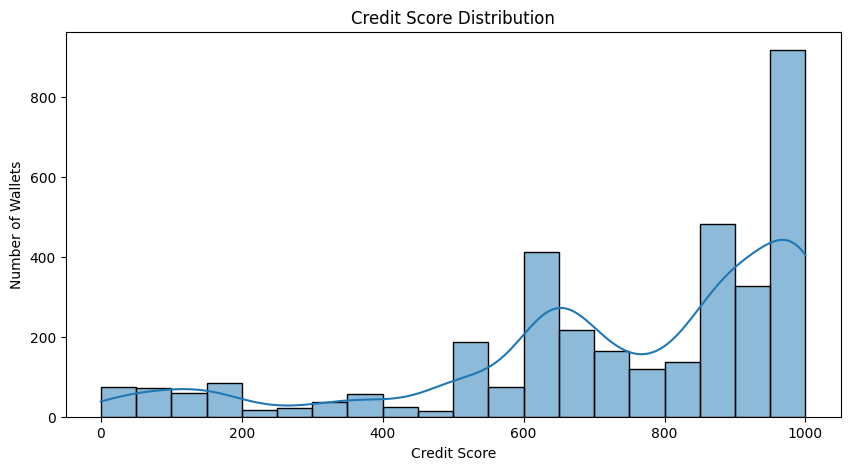

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(features['credit_score'], bins=20, kde=True)
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.show()


In [74]:
# Export scores
features[['userWallet', 'credit_score']].to_csv('/content/wallet_credit_scores.csv', index=False)


In [ ]:
from google.colab import files
files.download('/content/wallet_credit_scores.csv')
